In [6]:
import numpy as np
import mdtraj as mdt
import pathlib
import pytraj as pt
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint, check_grad
from scipy.interpolate import UnivariateSpline

from rotacf import rotacf


In [ ]:
traj = mdt.load("/data/gzappavigna/lmp_conf_builder/runs/6921a_132/cmap/traj.xtc", top="/data/gzappavigna/lmp_conf_builder/runs/cg.pdb")

In [7]:
traj = mdt.load("/data/gzappavigna/lmp_conf_builder/runs/6921a_132/cmap/traj.xtc", top="/data/gzappavigna/lmp_conf_builder/runs/cg.pdb")

/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/mdtraj/formats/pdb/pdbfile.py:206: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn(


In [8]:
corrs = {}
top = traj.topology

for res in list(top.residues):
    if res.index == 0 or res.name == "PRO":
        continue

    n_atom = next(atom for atom in res.atoms if atom.name == "N")
    h_atom = next(atom for atom in res.atoms if atom.name == "H")

    n_coords = traj.xyz[:, n_atom.index]
    h_coords = traj.xyz[:, h_atom.index]

    nh_vec = h_coords - n_coords

    # corr = pt.timecorr(nh_vec, nh_vec, tcorr=1e4, norm=True)
    corr = rotacf(nh_vec)
    if not np.isfinite(corr).all():
        print(res.resSeq)
        print(np.nonzero(~np.isfinite(corr)))
        raise Exception("Error!")

    corrs[res.resSeq] = corr



# TODO

- ~~do the fit for every residue and plot taus and A~~
- ~~interpolate data (?)~~
- ~~fit using curve_fit (write jac function ?)~~
- ~~store As and taus for each residue. We can start plotting these~~
- write function that generates J(omega) from As and taus
- use J and salvi's code to compute relaxation parameters..


In [11]:
# dt = 0.5 ps (2 fs * 250)
# t = np.arange(0, (1e4 + 1) * 0.5, 0.5)
t = np.arange(0, next(iter(corrs.values())).size) * 0.5

In [12]:
def sum_of_exps(t, As, lambdas, k):
    exp_terms = As[None, :] * np.exp(-lambdas[None, :] * t[:, None])
    return exp_terms.sum(axis=1) + k


def f(t, *params):
    As, lambdas, k = params_to_arr(params)

    return sum_of_exps(t, As, lambdas, k)

def loss(params, t, corr):
    As, lambdas, k = params_to_arr(params)

    return np.mean((sum_of_exps(t, As, lambdas, k) - corr) ** 2)


0.0
1505


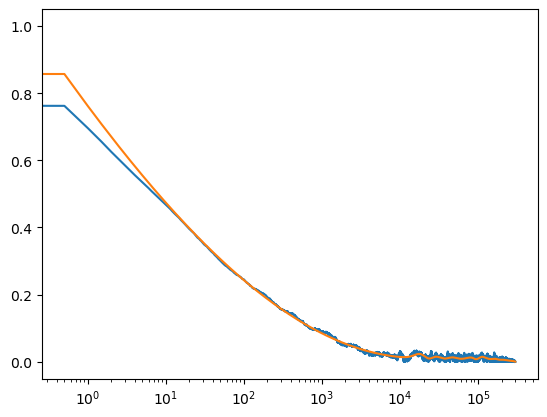

In [31]:
lasts = []
for resid, corr in corrs.items():
    print(t.min())
    new_t, new_corr = resample(t, corr)
    lasts.append(new_corr[-1])
    break

# plt.plot(lasts)
# plt.hlines(np.mean(lasts), 0, 120, colors="red")

In [23]:
np.mean(lasts)

0.10010050197229005

In [37]:
def params_to_arr(params):
    n = (params.size - 1) // 2
    As = np.asarray(params[:n])
    k = np.asarray(params[n:n+1])
    lambdas = np.asarray(params[n + 1:])

    return As, lambdas, k

def jac(params, t, corr):
    As, lambdas, k = params_to_arr(params)

    exps = np.exp(-lambdas[None, :] * t[:, None])

    A_grads = exps.copy()
    k_grads = np.ones_like(t)[:, None]
    lambda_grads = -As[None, :] * t[:, None] * exps

    grads = np.concatenate([A_grads, k_grads, lambda_grads], axis=1)

    f_t = sum_of_exps(t, As, lambdas, k)

    grad = 2 * grads * (f_t[:, None] - corr[:, None])

    return grad.mean(axis=0)


In [42]:
def resample(t, corr):
    # a, b = np.log(1), np.log(2e3)
    # delta = np.diff(t).mean()
    # n = (b - a) / np.log1p(np.exp(-a) * delta) + 1
    # print(n)
    # new_t = np.logspace(a, b, int(n), base=np.e)

    # mask = t >= 0.5
    # spl = CubicSpline(t[mask], corr[mask])
    # new_corr = spl(new_t)

    # mask = (t >= 10) & (t <= 5e3)

    assert t.size == corr.size
    ind = np.argmax(corr < 0.1)
    print(ind)
    mask = (t > 1) & (t < t[ind])

    new_t = t[mask]
    new_corr = corr[mask]

    return new_t, new_corr


def fit(t, corr, A0s, k0, tau0s):
    lambda0s = 1e-3 / tau0s
    scale = t.max()

    scaled_t = t / scale

    p0 = np.concatenate([A0s, k0, lambda0s * scale])

    eps = np.finfo(np.float32).eps
    assert check_grad(loss, jac, p0, scaled_t, corr) < eps

    bounds = [(0, 1)] * A0s.size + [(0, None)] * k0.size + [(scale * 1e-3 / 20, None)] * lambda0s.size

    res = minimize(loss, x0=p0, args=(scaled_t, corr), bounds=bounds, jac=jac, tol=1e-16, options={"maxiter": 1_000_000})

    As, scaled_lambdas, k = params_to_arr(res.x)

    tot = As.sum() + k
    As /= tot
    k /= tot

    # mask = scaled_lambdas < 1e-10
    # k += As[mask].sum()
    # As[mask] = 0
    # scaled_lambdas[mask] = scale

    # idx = np.argsort(lambdas)
    # lambdas = lambdas[idx]
    # As = As[idx]

    p0 = np.concatenate([As, k, scaled_lambdas])

    bounds = [(0, None)] * A0s.size + [(0, None)] * k0.size + [(scale * 1e-3 / 20, None)] * lambda0s.size
    cons = (
        LinearConstraint([[1] * A0s.size + [1] * k0.size + [0] * lambda0s.size], lb=1, ub=1),
        # LinearConstraint(
        #         [1, 1, 1, 1, 1, 0, 0, 0, 0], lb=1, ub=1),
        # LinearConstraint(
        #     [
        #         [0, 0, 0, 0, 0, -1, 1, 0, 0],
        #         [0, 0, 0, 0, 0, 0, -1, 1, 0],
        #         [0, 0, 0, 0, 0, 0, 0, -1, 1],
        #     ],
        #     lb=[0, 0, 0],
        # ),
    )
    res = minimize(loss, x0=p0, args=(scaled_t, corr), bounds=bounds, constraints=cons, jac=jac, tol=1e-16, options={"maxiter": 1_000_000})
    print(res.success)
    print(res.x[:A0s.size + k0.size].sum())
    As, scaled_lambdas, k = params_to_arr(res.x)
    lambdas = scaled_lambdas / scale
    taus = 1e-3 / lambdas

    return As, taus, k


def plot(fit_results):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

    As_taus = np.array([[As, taus] for As, taus, _ in fit_results.values()])

    As, taus = np.moveaxis(As_taus, 1, 0)

    idx = np.argsort(-taus, axis=1)
    # idx = np.argsort(-As, axis=1)

    As = np.take_along_axis(As, idx, axis=1)
    taus = np.take_along_axis(taus, idx, axis=1)

    axes[0, 0].plot(As[:, 0])
    axes[0, 1].plot(As[:, 1])

    axes[1, 0].semilogy(taus[:, 0])
    axes[1, 1].semilogy(taus[:, 1])

    plt.show()


1388
True
1.0
3136
True
1.0
4685
True
1.0
6635
True
1.0
6634


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


True
1.0
7216
True
1.0
7392
True
1.0
5010
True
1.0
9459
True
1.0
6296
True
1.0
11556
True
1.0
14723
True
1.0
10604
True
1.0
5197
True
1.0
18301
True
1.0
14207
True
1.0
10621
True
1.0
9721
True
1.0
9135


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


True
1.0
12490
True
1.0
8598
True
1.0
8482
True
1.0
6196
True
1.0
12715


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


True
1.0
11274
True
1.0
11483
True
1.0
12477
True
1.0
11860
True
1.0
8173


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


True
1.0
7130
True
1.0
8141
True
1.0
6004
True
1.0
11114


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


True
1.0
12784


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


True
1.0
8928
True
1.0
12684
True
1.0
6151
True
1.0
5263
True
1.0
10976


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


True
1.0
6016
True
1.0
10037
True
1.0
25191
True
1.0
19269
True
1.0
26479
True
1.0
9525
True
1.0
25771
True
1.0
70490
True
1.0
17419


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


True
1.0
5146
True
1.0
6190
True
1.0
6756
True
1.0
8788
True
1.0
6038
True
1.0
21605
True
1.0
18998
True
1.0
8508
True
1.0
15074
True
1.0
19267
True
1.0
17873
True
1.0
15457
True
1.0
19577
True
1.0
24864


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


True
1.0
22625
True
1.0
23140
True
1.0
19875


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


True
1.0
20854
True
1.0
15297
True
1.0
9124
True
1.0
9850
True
1.0
22756
True
1.0
23057
True
1.0
15686
True
1.0
11118


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


True
1.0
9358


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


True
1.0
13140
True
1.0
8474


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


True
1.0
10185
True
1.0
9355
True
1.0
6678
True
1.0
7136
True
1.0
10881
True
1.0
7745
True
1.0
9732


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


True
1.0
9882
True
1.0
10213
True
1.0
8698
True
1.0
9178
True
1.0
4807
True
1.0
11751
True
1.0
18663
True
1.0
34668
True
1.0
15875
True
1.0
19161
True
1.0
12884
True
1.0
13972
True
1.0
20561
True
1.0
17014


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


True
1.0
17273
True
1.0
22611


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


True
1.0
25174
True
1.0
23241
True
1.0
13097
True
1.0
18157
True
1.0
9195
True
1.0
8957
True
1.0
6977
True
1.0
9502


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


True
1.0
6172
True
1.0
9088
True
1.0
7501
True
1.0
5111
True
1.0
6730
True
1.0
11656
True
1.0
12704


/home/gzappavigna/miniforge3/envs/lab/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


True
1.0
9977
True
1.0
8574
True
1.0
8906
True
1.0
7873
True
1.0
4942
True
1.0
5014
True
1.0
7454
True
1.0
2612
True
1.0
2020
True
1.0
709
True
1.0


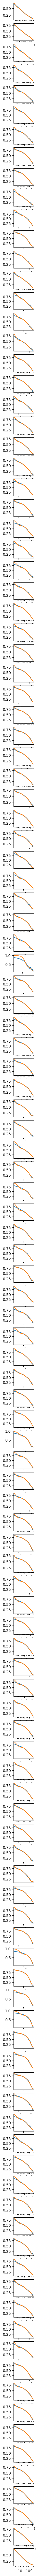

In [43]:
fit_results = {}

A0s = 2.0 ** -np.arange(1, 3 + 1)
# A0s = np.array([0.4, 0.3, 0.2])
k0 = np.array([1 - A0s.sum()])
tau0s = np.ones(3)

fig, axes = plt.subplots(nrows=len(corrs), ncols=1, figsize=(1, 1 * len(corrs)))

for ax, (resid, corr) in zip(axes, corrs.items()):
    new_t, new_corr = resample(t, corr)
    As, taus, k = fit(new_t, new_corr, A0s, k0, tau0s)
    # print(As, taus)

    lambdas = 1e-3 / taus
    fit_corr = sum_of_exps(new_t, As, lambdas, k)

    ax.semilogx(new_t, new_corr)
    ax.semilogx(new_t, fit_corr)

    fit_results[resid] = (As, taus, k)
    # A0s, k0, tau0s = As, taus, k

plt.show()

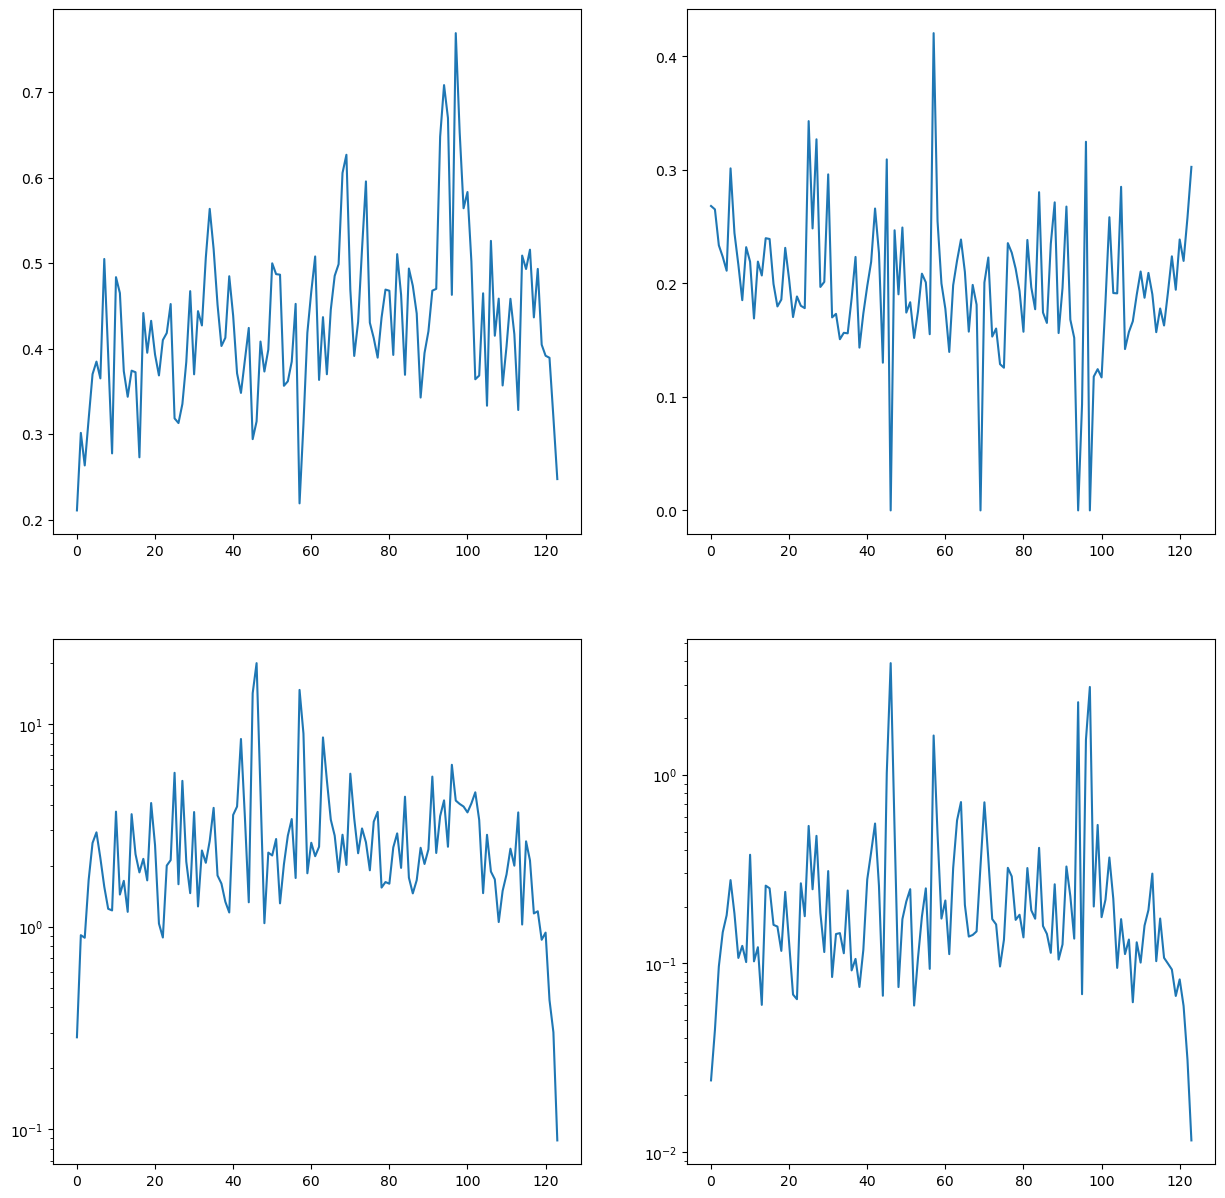

In [44]:
plot(fit_results)
plt.show()

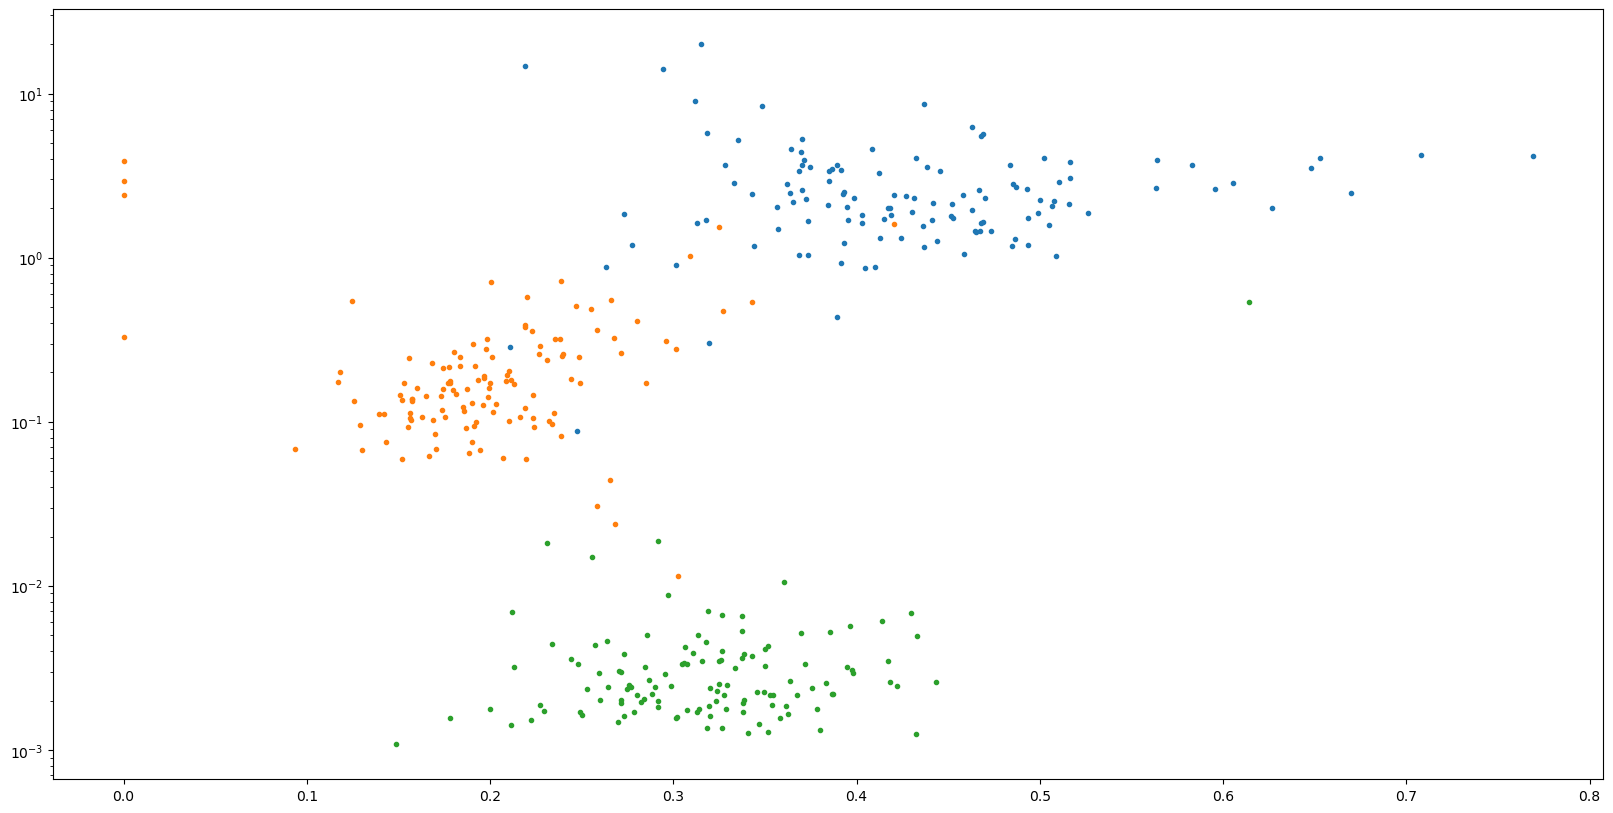

In [45]:
As_taus = np.array([[As, taus] for As, taus, _ in fit_results.values()])

As, taus = np.moveaxis(As_taus, 1, 0)

idx = np.argsort(-taus, axis=1)

As = np.take_along_axis(As, idx, axis=1)
taus = np.take_along_axis(taus, idx, axis=1)

plt.yscale("log")
fig = plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(10)
# plt.figure(figsize=(10, 5))

for i in range(As.shape[1]):
    plt.scatter(As[:, i], taus[:, i], marker=".")

In [1]:
taus.mean(axis=0)

NameError: name 'taus' is not defined

In [301]:
As.mean(axis=0)

array([0.42638552, 0.19282184, 0.33632929])

In [ ]:
from scipy.integrate import cumulative_simpson, cumulative_trapezoid

x_pows = []
y_integs = []

cur_integ = new_corr.copy()

n = 4

for i in range(n):
    cur_integ = cumulative_simpson(cur_integ, x=new_t, initial=0.0)
    # cur_integ = cumulative_trapezoid(cur_integ, x=new_t, initial=0.0)
    y_integs.append(cur_integ)

    # x_pow = new_t ** (n - i - 1)
    x_pow = new_t ** i
    x_pows.append(x_pow)

# Y = np.stack(y_integs[:-1] + x_pows, axis=-1)
Y = np.stack(y_integs + x_pows, axis=-1)

A = np.linalg.pinv(Y) @ new_corr
# A = np.linalg.lstsq(Y, new_corr, rcond=None)[0]


In [ ]:
# lambdas = np.linalg.eigvals(np.concatenate([A[None, :n], np.eye(n)[:-1, :]]))
lambdas = np.linalg.eigvals(np.concatenate([A[None, :n], np.eye(n)[:-1, :]]))
# lambdas = np.append(0, lambdas)

X = np.exp(lambdas[None, :] * new_t[:, None])

# lambdas = np.linalg.eigvals(np.concatenate([A[None, :n], np.eye(n)[:-1, :]]))
# X = np.exp(lambdas[None, :] * new_t[:, None])

# P = np.linalg.pinv(X) @ new_corr
P = np.linalg.lstsq(X, new_corr, rcond=None)[0]



In [ ]:
A

In [ ]:
np.concatenate([A[None, :n], np.eye(n)[:-1, :]])

In [ ]:
-(1/lambdas) / 1e3

In [ ]:
P

In [ ]:
P / P.sum()

In [ ]:
from scipy.optimize import curve_fit




In [ ]:
P, lambdas = res[0].reshape(2, -1)

In [ ]:
plt.semilogx(new_t, new_corr)

# exps = np.exp(lambdas[None, :] * new_t[:, None])
# exps = np.exp(np.concatenate([np.ones_like(new_t)[:, None], lambdas[None, :] * new_t[:, None]], axis=1))

fit_corr = P[None, :] * np.exp(lambdas[None, :] * new_t[:, None])
fit_corr = fit_corr.sum(1)

plt.semilogx(new_t, fit_corr)

In [ ]:
ysv = np.linalg.svd(Y)[1]

ysv_scaled = ysv / ysv.sum()
thres = 0.1
n_ysv_scaled = ysv_scaled[ysv_scaled > thres]
N = n_ysv_scaled.size / 2
print(N)

In [ ]:
np.linalg.svd(Y)[1]

In [ ]:
plt.plot(np.cumsum(ysv_scaled))